<a href="https://colab.research.google.com/github/kinianlo/prlang/blob/main/archive/adj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PR-like models in langauge


### Generate PR-like models with Masked LM 

In [16]:
!pip install numpy inflect torch transformers git+https://github.com/kinianlo/contextuality.git

  Cloning https://github.com/kinianlo/contextuality.git to /tmp/pip-req-build-jizaogey
  Running command git clone -q https://github.com/kinianlo/contextuality.git /tmp/pip-req-build-jizaogey


In [17]:
import itertools
import numpy as np
import inflect
import random
import json
import pandas as pd
from tqdm.auto import tqdm
from time import time

from contextuality.model import Model, CyclicScenario

import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [18]:
def get_probs(sentences_raw, options, model, tokenizer, mask_placeholder='_'):
    """
    Predict a masked word with probability scores for the provided options
    for the mask.
    
    Parameters
    ---------
    sentences_raw : str or (list of str)
    options : (list of str) or (list of (list of str))
    model : MaskedLM
    tokenizer : Tokenizer
    """
    torch.cuda.empty_cache()
    if type(sentences_raw) is str:
        sentences_raw = [sentences_raw]
    if type(options[0]) is str:
        options = [options for s in sentences_raw]
    
    partition_size = 2**8
    n_sentence = len(sentences_raw)
    if n_sentence > partition_size:
        print(f"Processing {n_sentence} sentences. Batching...")
        probs = []
        for i in tqdm(range(0, len(sentences_raw), partition_size)):
            sentences_raw_part = sentences_raw[i:i+partition_size]
            options_part = options[i:i+partition_size]
            probs += get_probs(sentences_raw_part, options_part, model,
                               tokenizer, mask_placeholder=mask_placeholder)
        return probs
        
    # Convert the option words into tokens
    options_token = [[tokenizer.tokenize(op)[0] for op in ops] for ops in options]
    options_id = [[tokenizer.vocab[op] for op in ops] for ops in options_token]
    
    # Replace mask placeholders with the mask token used by the given tokenizer
    sentences = [s.replace(mask_placeholder, tokenizer.mask_token) for s in sentences_raw]
    inputs = tokenizer(sentences, return_tensors='pt', padding=True).to(model.device)
    
    mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)
    
    outputs = model(**inputs)
    logits = outputs.logits
    
    mask_logits = logits[mask_indices]
    
    probs = [[] for i in range(len(sentences))]
    
    for i in range(len(mask_indices[0])):
        s_idx, m_idx = mask_indices[0][i], mask_indices[1][i]
        prob = torch.softmax(mask_logits[i][options_id[s_idx]], dim=-1).detach().cpu().numpy()
        prob = dict(zip(options[s_idx], prob))
        probs[s_idx] = prob
        
    if len(probs) == 1:
        probs = probs[0]
    return probs

In [19]:
# Initialise the language model and its tokenizer
device = "cuda:0" if torch.cuda.is_available() else "cpu"
lm_name = 'bert-base-uncased'
mlm = AutoModelForMaskedLM.from_pretrained(lm_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(lm_name)

## The following handles a batch of examples
Examples should be given in a text file where each row has the format:

```outcome1 outcome2: observable1 observable2 observable3 observable4 ...```

For example,

```apple strawberry: sweet red round green big```

For each row, all ordered combinations of 3 observables will be considered in the following.

In [20]:
def process_topics_file(file_name):
    topics = []
    with open(file_name) as file:
        for row in file:
            if not row.strip():
                continue
            outcomes = [] 
            observables = []
            outcomes_str, observables_str = map(str.strip, row.split(':'))
            outcomes = list(map(str.strip, set(outcomes_str.split(','))))
            observables = list(map(str.strip, set(observables_str.split(','))))
            topics.append((outcomes, observables))
    return topics

def process_schemas_file(file_name):
    schema_options = dict()
    schemas = dict()
    with open(file_name) as file:
        data = json.load(file)
        schema_options = data['options']
        schemas = data['schemas']
    return schema_options, schemas

In [21]:
def generate_scenarios(topics, schema=None):
    scenarios = []
    for topic in topics:
        outcomes, observables = topic
        out_perm = itertools.permutations(outcomes, 2)
        obs_perm = itertools.permutations(observables, 3)
        scenarios += list(itertools.product(out_perm, obs_perm))
    return scenarios

In [22]:
def a(word):
    """Return `a` or `an` depending on the given word.
    """
    return inflect.engine().a(word)

def generate_sentences(scenario, schema):
    sentences = []
    o, x = scenario
    if schema == 'adj':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and the same one is {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and the same one is {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    elif schema == 'verb':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is being {x[0]} and the same one is being {x[1]}.")
        sentences.append(f"{intro} The _ is being {x[1]} and the same one is being {x[2]}.")
        sentences.append(f"{intro} The _ is being {x[2]} and the other one is being {x[0]}.")
    elif schema == 'prep':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and the same one is {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and the same one is {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    return sentences

def get_mask_options(scenario, schema):
    o, x = scenario
    return [o for i in range(3)]

# Load topics files here!


In [23]:
%cd
%rm -rf prlang
!git clone https://github.com/kinianlo/prlang.git
%cd prlang

/root
Cloning into 'prlang'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 101 (delta 51), reused 55 (delta 19), pack-reused 0
Receiving objects: 100% (101/101), 134.45 KiB | 6.11 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/root/prlang


In [24]:
topics = process_topics_file('data/adj.txt')
schema = 'adj'

print(f'Topics for schema `{schema}`:')
for t in topics:
    print(t)

Topics for schema `adj`:
(['dog', 'cat'], ['wild', 'house', 'little', 'dead', 'black', 'lovely', 'friendly', 'small', 'large', 'cute', 'thirsty', 'sweet', 'hungry', 'young', 'gray', 'furry', 'big', 'good'])
(['girl', 'boy'], ['baby', 'beautiful', 'small', 'teenage', 'little', 'young', 'pretty'])
(['man', 'woman'], ['little', 'dead', 'tall', 'strange', 'beautiful', 'young', 'big'])
(['apple', 'strawberry'], ['rotten', 'round', 'sweet', 'red', 'sour'])
(['marigold', 'daisy'], ['beautiful', 'yellow', 'everywhere', 'small'])
(['sunflower', 'daisy'], ['beautiful', 'yellow', 'small'])
(['butterfly', 'moth'], ['winged', 'colorful', 'beautiful', 'light'])
(['cucumber', 'courgette'], ['juicy', 'long', 'green', 'tasty'])
(['dolphin', 'porpoise'], ['wet', 'slippery', 'slim', 'grey'])
(['yam', 'potato'], ['healthy', 'starchy', 'big', 'orange'])
(['bus', 'car'], ['fast', 'heavy', 'safe', 'sturdy'])


In [25]:
df = pd.DataFrame(columns=['nouns', 'modifiers', 'models', 'contextual_models'])

sfs_list = []
sheaf_models_list = []

for topic in topics:
    row = dict()
    scenarios = generate_scenarios([topic], schema)
    print(f"Curent topic: {topic}")
    row['nouns'], row['modifiers'] = topic

    n_scenario = len(scenarios)
    row['models'] = n_scenario
    print(f"Number of scenarios: {n_scenario}")
    
    sentences = [generate_sentences(scen, schema) for scen in scenarios]
    sentences_flat = list(itertools.chain.from_iterable(sentences))

    mask_options = [get_mask_options(scen, schema) for scen in scenarios]
    mask_options_flat = list(itertools.chain.from_iterable(mask_options))

    probs_flat = get_probs(sentences_flat, mask_options_flat, mlm, tokenizer)
    probs = [probs_flat[3*i:3*i+3] for i in range(n_scenario)]

    sheaf_models = []
    cbd_models = []
    sfs = []
    cbds = []
    for i in range(n_scenario):
        outcomes, observables = scenarios[i]
        tri_scenario = CyclicScenario(observables, 2)
        o0, o1 = outcomes
        x0, x1, x2 = observables
        
        table = []
        table.append([probs[i][0][o0], 0, 0, probs[i][0][o1]])
        table.append([probs[i][1][o0], 0, 0, probs[i][1][o1]])
        table.append([0, probs[i][2][o0], probs[i][2][o1], 0])
        
        model = Model(tri_scenario, table)
        sfs.append(model.signalling_fraction())
        cbds.append(model.CbD_measure())
        if sfs[-1] < 1/6:
            sheaf_models.append(model)
            for s in sentences[i]:
                print(s)
            print(model)
            print(f"Signalling fraction: {model.signalling_fraction()}")
            print(f"\\model{{{o0}}}{{{o1}}}{{{x0}}}{{{x1}}}{{{x2}}}{{{probs[i][0][o0]}}}{{{probs[i][1][o0]}}}{{{probs[i][2][o0]}}}")
            print('='*60)
        
        if cbds[-1] > 0:
            cbd_models.append(model)
    sheaf_models_list += sheaf_models
    sfs_list += sfs
    row['contextual_models'] = len(sheaf_models)
    df = df.append(row, ignore_index=True)

Curent topic: (['dog', 'cat'], ['wild', 'house', 'little', 'dead', 'black', 'lovely', 'friendly', 'small', 'large', 'cute', 'thirsty', 'sweet', 'hungry', 'young', 'gray', 'furry', 'big', 'good'])
Number of scenarios: 9792
Processing 29376 sentences. Batching...


  0%|          | 0/115 [00:00<?, ?it/s]

There is a dog and a cat. The _ is wild and the same one is lovely.
There is a dog and a cat. The _ is lovely and the same one is dead.
There is a dog and a cat. The _ is dead and the other one is wild.
               (0, 0) (0, 1) (1, 0) (1, 1)
(wild, lovely) 0.5316 0.0000 0.0000 0.4684
(lovely, dead) 0.4783 0.0000 0.0000 0.5217
(dead, wild) 0.0000 0.4445 0.5555 0.0000

Signalling fraction: 0.11104285540890213
\model{dog}{cat}{wild}{lovely}{dead}{0.5316187739372253}{0.4782644212245941}{0.4444785714149475}
There is a dog and a cat. The _ is wild and the same one is lovely.
There is a dog and a cat. The _ is lovely and the same one is black.
There is a dog and a cat. The _ is black and the other one is wild.
                (0, 0) (0, 1) (1, 0) (1, 1)
(wild, lovely) 0.5316 0.0000 0.0000 0.4684
(lovely, black) 0.5223 0.0000 0.0000 0.4777
(black, wild) 0.0000 0.4937 0.5063 0.0000

Signalling fraction: 0.06323754785257218
\model{dog}{cat}{wild}{lovely}{black}{0.5316187739372253}{0.52228754

  0%|          | 0/5 [00:00<?, ?it/s]

There is a girl and a boy. The _ is young and the same one is small.
There is a girl and a boy. The _ is small and the same one is little.
There is a girl and a boy. The _ is little and the other one is young.
                (0, 0) (0, 1) (1, 0) (1, 1)
(young, small) 0.5711 0.0000 0.0000 0.4289
(small, little) 0.5655 0.0000 0.0000 0.4345
(little, young) 0.0000 0.5280 0.4720 0.0000

Signalling fraction: 0.14220005236459887
\model{girl}{boy}{young}{small}{little}{0.5711000561714172}{0.5654845833778381}{0.52799391746521}
Curent topic: (['man', 'woman'], ['little', 'dead', 'tall', 'strange', 'beautiful', 'young', 'big'])
Number of scenarios: 420
Processing 1260 sentences. Batching...


  0%|          | 0/5 [00:00<?, ?it/s]

There is a man and a woman. The _ is dead and the same one is tall.
There is a man and a woman. The _ is tall and the same one is strange.
There is a man and a woman. The _ is strange and the other one is dead.
                (0, 0) (0, 1) (1, 0) (1, 1)
(dead, tall) 0.5045 0.0000 0.0000 0.4955
(tall, strange) 0.4276 0.0000 0.0000 0.5724
(strange, dead) 0.0000 0.4177 0.5823 0.0000

Signalling fraction: 0.16455435748418235
\model{man}{woman}{dead}{tall}{strange}{0.5044633150100708}{0.42758995294570923}{0.41772282123565674}
There is a man and a woman. The _ is dead and the same one is big.
There is a man and a woman. The _ is big and the same one is young.
There is a man and a woman. The _ is young and the other one is dead.
              (0, 0) (0, 1) (1, 0) (1, 1)
(dead, big) 0.5605 0.0000 0.0000 0.4395
(big, young) 0.5117 0.0000 0.0000 0.4883
(young, dead) 0.0000 0.5371 0.4629 0.0000

Signalling fraction: 0.12103396644607622
\model{man}{woman}{dead}{big}{young}{0.5605169534683228}{0.5

  0%|          | 0/2 [00:00<?, ?it/s]

Curent topic: (['marigold', 'daisy'], ['beautiful', 'yellow', 'everywhere', 'small'])
Number of scenarios: 48
Curent topic: (['sunflower', 'daisy'], ['beautiful', 'yellow', 'small'])
Number of scenarios: 12
Curent topic: (['butterfly', 'moth'], ['winged', 'colorful', 'beautiful', 'light'])
Number of scenarios: 48
Curent topic: (['cucumber', 'courgette'], ['juicy', 'long', 'green', 'tasty'])
Number of scenarios: 48
Curent topic: (['dolphin', 'porpoise'], ['wet', 'slippery', 'slim', 'grey'])
Number of scenarios: 48
Curent topic: (['yam', 'potato'], ['healthy', 'starchy', 'big', 'orange'])
Number of scenarios: 48
Curent topic: (['bus', 'car'], ['fast', 'heavy', 'safe', 'sturdy'])
Number of scenarios: 48


In [26]:
df

,nouns,modifiers,models,contextual_models
0,"[dog, cat]","[wild, house, little, dead, black, lovely, fri...",9792,344
1,"[girl, boy]","[baby, beautiful, small, teenage, little, youn...",420,1
2,"[man, woman]","[little, dead, tall, strange, beautiful, young...",420,5
3,"[apple, strawberry]","[rotten, round, sweet, red, sour]",120,0
4,"[marigold, daisy]","[beautiful, yellow, everywhere, small]",48,0
5,"[sunflower, daisy]","[beautiful, yellow, small]",12,0
6,"[butterfly, moth]","[winged, colorful, beautiful, light]",48,0
7,"[cucumber, courgette]","[juicy, long, green, tasty]",48,0
8,"[dolphin, porpoise]","[wet, slippery, slim, grey]",48,0
9,"[yam, potato]","[healthy, starchy, big, orange]",48,0


total number of scenarios: 11052.
total number sheaf-contextual scenarios: 350(3.17%).


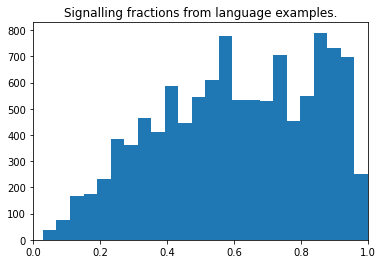

\histogram{(0.0000, 7) (0.0417, 63) (0.0833, 100) (0.1250, 180) }{(0.1667, 223) (0.2083, 295) (0.2500, 376) (0.2917, 391) (0.3333, 397) (0.3750, 707) (0.4167, 489) (0.4583, 396) (0.5000, 716) (0.5417, 748) (0.5833, 615) (0.6250, 502) (0.6667, 580) (0.7083, 549) (0.7500, 625) (0.7917, 545) (0.8333, 798) (0.8750, 723) (0.9167, 723) (0.9583, 304) }


In [31]:
import matplotlib.pyplot as plt
print(f"total number of scenarios: {len(sfs_list)}.")
print(f"total number sheaf-contextual scenarios: {len(sheaf_models_list)}({len(sheaf_models_list)/len(sfs_list)*100:.2f}%).")
plt.hist(sfs_list, bins=24)

plt.xlim((0,1))
plt.title("Signalling fractions from language examples.")
plt.show()

freq, edge = np.histogram(sfs_list, range=(0, 1), bins=24)
out1 = ''
out2 = ''
for f, e in zip(freq, edge[:-1]):
    if e < 1/6-1e-5:
        out1 += f"({e:.4f}, {f}) "
    else:
        out2 += f"({e:.4f}, {f}) "
print(f'\\histogram{{{out1}}}{{{out2}}}')

In [28]:
# print(f"total number of scenarios: {len(cbds)}.")
# plt.hist(cbds, bins=50)

# plt.title("CbD from language examples.")
# plt.show()

In [29]:
# print(cbd_models[0])
# print(cbd_models[0].CbD_measure())

In [30]:
# from contextuality.model import random_pr_like_model
# random_sfs = []
# for i in range(n_scenario):
#     model = random_pr_like_model(3)
#     random_sfs.append(model.signalling_fraction())

# plt.hist(random_sfs, bins=50)
# plt.xlim((0,1))
# plt.title("Signalling fractions from random models")
# plt.show()